In [1]:
import numpy as np

import sys
import time
sys.path.append("./Models")
import os
os.system('')

import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "aep" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
param_dset_lookback_weeks = 5
param_dset_forecast = 48 if arg_dset == "lsm" else 24
# param_dset_lookback_weeks = 9
# param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False


In [3]:
import pywt
from tqdm.auto import tqdm

# Get the maximum decomposition level
def print_maximal_decom_level(data):
    max_level = pywt.swt_max_level(data)
#     print("Maximum decomposition level:", max_level)
    
    return max_level

# SWT functions
def data_preparation(dataset, window, lev):
    '''
    Converts time series to wave
    '''
    da = []
    coeffs = []
    
#     for i in tqdm(range(len(dataset)), total=len(dataset), desc="swt"):
    for i in range(len(dataset)):
        for j in range(len(dataset[0])-window):
            coeffs_j = pywt.swt(dataset[i][j:window+j], wavelet='db2', level=lev)
            coeffs.append(coeffs_j)
            
        da.append(coeffs);
        coeffs = []
    return da

def data_reconstruction(dataset, window):
    '''
    Converts wave back to time series
    Take window-1 (last) value since we predict this value based on window
    '''
    full_recon = []
#     for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
    for i in range(len(dataset)):
        da = []
        for j in range(len(dataset[0])):
            recon = pywt.iswt(dataset[i][j], 'db2')
            da.append(recon[window-1])
        full_recon.append(da)

    return full_recon


# Called because iswt cannot accept tolist() dataset
def data_organization(data):
    '''
    Reshape data back to (n,m,3,2,window_length), 
    n number of different household, m number of timelines
    where there are 3 tuples of 2 values consisting of 
    coeffs array_like Coefficients list of tuples:
    [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)]
    '''
    full_reshape_list = []
    for i in range(len(data)):
        reshape_list = []
        for j in range(len(data[0])):
            reshape_list.append([])
            for k in range(len(data[0][0])):
                reshape_list[j].append(tuple(data[i][j][k]))
        
        full_reshape_list.append(reshape_list)    
    
    return full_reshape_list

In [4]:
from dayton_def import DAYTON

#Compute remaining settings
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast
if param_dset_train_stride == 'same': param_dset_train_stride = param_dset_forecast
if param_dset_test_stride == 'same': param_dset_test_stride = param_dset_forecast
attr_dset_smpl_rt = {'ree':24,'aep':24,'lsm':48, 'dyt':24}[arg_dset]

param_trf_inp_dim = {'ree':7,'lsm': 14}[arg_dset] if param_trf_weather else 1

In [5]:
full_set = DAYTON(path = ".",
                  seq_len = param_dset_lookback,
                  pred_horz = param_dset_forecast,
                  timestamp = False)
dytmax = full_set.max()
dytmin = full_set.min()
del(full_set)

train_set = DAYTON(path = ".",
                start_idx = 0, end_idx = 97036,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=29,
                timestamp = False)
val_set = DAYTON(path = ".",
              start_idx = 97036, end_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)
test_set = DAYTON(path = ".",
                start_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)


train_set.series = (train_set.series - dytmin)/(dytmax - dytmin)
val_set.series = (val_set.series - dytmin)/(dytmax - dytmin)
test_set.series = (test_set.series - dytmin)/(dytmax - dytmin)

print(test_set.series.shape)

torch.Size([471, 840, 1])


## Model Initialization

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# path1 = "/content/gdrive/MyDrive/FYP/Models"
# path2 = "/content/gdrive/MyDrive/FYP/Models/BigBirdSparse"
# import sys
# sys.path.insert(1,path1)
# sys.path.insert(2,path2)
import sys
sys.path.append("../../Models")

from Encodings.encoding import LearnablePositionalEncoding
from BigBirdSparse.bb_sparse import BlockSparseMultiheadAttention
from BigBirdSparse.bb_fixed import BlockSparseFixedAttention
from transformer_base import TBatchNorm

class TransformerBBSparse(nn.Module):
    def __init__(self, seq_len=2560, out_seq_len=24, interval=1, inp_dim=1, emb_dim=64,\
                 n_heads=4, n_enc_layers=2, n_dec_layers=2, block_size=40,\
                ffdim=128, drop_p = 0.1):
        super(TransformerBBSparse,self).__init__()
        self.seq_len = seq_len
        self.out_seq_len = out_seq_len
        self.emb_dim = emb_dim
        #self.in_norm = nn.BatchNorm1d(seq_len,affine=False)
        self.input_linear = nn.Linear(inp_dim,emb_dim)
        #self.input_pool = nn.AvgPool1d(kernel_size=5,stride=5)
        self.pe = LearnablePositionalEncoding(emb_dim,dropout=0.1,max_len=seq_len)
        #self.pe = CosineEmbedding(emb_dim,max_len=seq_len,scale_factor=0.1)
        #self.tpe = TimestampCosineEmbedding(emb_dim, interval, max_len = seq_len)

        self.trf_el = nn.TransformerEncoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)
        self.trf_el.self_attn = BlockSparseMultiheadAttention(emb_dim, n_heads, block_size,batch_first=True)
        #self.trf_el.self_attn = BlockSparseMheadAttnFixed(emb_dim, n_heads, block_size,batch_first=True)

        self.trf_dl = nn.TransformerDecoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)

        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm2 = TBatchNorm(num_features=emb_dim)

        self.trf_dl.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm2 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm3 = TBatchNorm(num_features=emb_dim)

        self.trf_e = nn.TransformerEncoder(self.trf_el,num_layers=n_enc_layers)
        self.trf_d = nn.TransformerDecoder(self.trf_dl,num_layers=n_dec_layers)

        # self.out = nn.Linear(emb_dim,inp_dim)
        self.out = nn.Linear(emb_dim,1)
        self.drop = nn.Dropout(p=drop_p)

        # self.dec_tar = torch.nn.Parameter(torch.zeros((out_seq_len,emb_dim)))
        # nn.init.normal_(self.dec_tar)
        self.aux_out = nn.Linear(emb_dim,1)#inp_dim)
        #self.reduce = nn.Linear(seq_len,out_seq_len)
        self.aux_in = nn.Linear(1,emb_dim)#inp_dim,emb_dim)

        self.expand = nn.Linear(seq_len,5120)
        self.compress = nn.Linear(5120,out_seq_len)

    def forward(self,x):
        '''x: [batch dim, sequence length, variable dim]'''
        x1 = self.input_linear(x) # x1.shape: [batch, seq len, emb dim]
        x1 = self.pe(x1.permute(1,0,2)).permute(1,0,2)
        #x1 = self.tpe(x1.permute(1,0,2),in_start_time).permute(1,0,2)
        mem = self.trf_e(x1)

        dec_in = self.aux_out(mem)
        dec_in = F.gelu(self.expand(dec_in.view((-1,self.seq_len))))
        dec_in = self.drop(dec_in)
        dec_in = self.compress(dec_in)
        #dec_in = F.gelu(self.reduce(dec_in.view((-1,self.seq_len))))

        dec_in = self.aux_in(dec_in.unsqueeze(-1))

        # x2 = self.trf_d(self.dec_tar.broadcast_to(x.shape[0],self.out_seq_len,self.emb_dim)\
        #                 ,mem)
        x2 = self.trf_d(self.pe(dec_in.permute(1,0,2))\
                        .permute(1,0,2),mem)
        # x2 = self.trf_d(self.tpe(dec_in.permute(1,0,2),pred_start_time)\
        #                 .permute(1,0,2),mem)

        o1 = self.out(x2)

        return o1



In [7]:
class TransformerBBFixed(nn.Module):
    def __init__(self, seq_len=2560, out_seq_len=24, interval=1, inp_dim=1, emb_dim=64,\
                 n_heads=4, n_enc_layers=2, n_dec_layers=2, block_size=40,\
                ffdim=128, drop_p = 0.1):
        super(TransformerBBFixed,self).__init__()
        self.seq_len = seq_len
        self.out_seq_len = out_seq_len
        self.emb_dim = emb_dim
        #self.in_norm = nn.BatchNorm1d(seq_len,affine=False)
        self.input_linear = nn.Linear(inp_dim,emb_dim)
        #self.input_pool = nn.AvgPool1d(kernel_size=5,stride=5)
        self.pe = LearnablePositionalEncoding(emb_dim,dropout=drop_p,max_len=seq_len)
        #self.pe = CosineEmbedding(emb_dim,max_len=seq_len,scale_factor=0.1)
        #self.tpe = TimestampCosineEmbedding(emb_dim, interval, max_len = seq_len)

        self.trf_el = nn.TransformerEncoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)
        #self.trf_el.self_attn = BlockSparseMultiheadAttention(emb_dim, n_heads, block_size,batch_first=True)
        self.trf_el.self_attn = BlockSparseFixedAttention(emb_dim, n_heads, block_size,batch_first=True)

        self.trf_dl = nn.TransformerDecoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)

        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm2 = TBatchNorm(num_features=emb_dim)

        self.trf_dl.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm2 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm3 = TBatchNorm(num_features=emb_dim)

        self.trf_e = nn.TransformerEncoder(self.trf_el,num_layers=n_enc_layers)
        self.trf_d = nn.TransformerDecoder(self.trf_dl,num_layers=n_dec_layers)

        # self.out = nn.Linear(emb_dim,inp_dim)
        self.out = nn.Linear(emb_dim,1)
        self.drop = nn.Dropout(p=drop_p)

        # self.dec_tar = torch.nn.Parameter(torch.zeros((out_seq_len,emb_dim)))
        # nn.init.normal_(self.dec_tar)
        self.aux_out = nn.Linear(emb_dim,1)#inp_dim)
        #self.reduce = nn.Linear(seq_len,out_seq_len)
        self.aux_in = nn.Linear(1,emb_dim)#inp_dim,emb_dim)

        self.expand = nn.Linear(seq_len,5120)
        self.compress = nn.Linear(5120,out_seq_len)

    def forward(self,x):
        '''x: [batch dim, sequence length, variable dim]'''
        x1 = self.input_linear(x) # x1.shape: [batch, seq len, emb dim]
        x1 = self.pe(x1.permute(1,0,2)).permute(1,0,2)
        #x1 = self.tpe(x1.permute(1,0,2),in_start_time).permute(1,0,2)
        mem = self.trf_e(x1)

        dec_in = self.aux_out(mem)
        dec_in = F.gelu(self.expand(dec_in.view((-1,self.seq_len))))
        dec_in = self.drop(dec_in)
        dec_in = self.compress(dec_in)
        #dec_in = F.gelu(self.reduce(dec_in.view((-1,self.seq_len))))

        dec_in = self.aux_in(dec_in.unsqueeze(-1))

        # x2 = self.trf_d(self.dec_tar.broadcast_to(x.shape[0],self.out_seq_len,self.emb_dim)\
        #                 ,mem)
        x2 = self.trf_d(self.pe(dec_in.permute(1,0,2))\
                        .permute(1,0,2),mem)
        # x2 = self.trf_d(self.tpe(dec_in.permute(1,0,2),pred_start_time)\
        #                 .permute(1,0,2),mem)

        o1 = self.out(x2)

        return o1

## Create model and data tensor

In [8]:
#SWT Transformation
def swt_transformation(self_series, window, lev):
    self_series = self_series.squeeze(-1)
#     print("total series shape after squeeze: ", self_series.shape)
    self_series_numpy = self_series.numpy()
#     print("torch shape: ", self_series.shape)
#     print("numpy shape: ", self_series_numpy.shape)
#     print(self_series[0])
#     print(self_series_numpy[0])

    da = data_preparation(self_series_numpy, window, lev)
#     print(da[0][0])

    Vv = np.array(da)
#     print(Vv.shape)
#     print(Vv[0][0])

    vv = Vv.reshape(Vv.shape[0],Vv.shape[1],2*lev*Vv.shape[4])
#     print(vv.shape)


    # dataset = scaler.fit_transform(vv)

    dat = vv.reshape(Vv.shape[0],Vv.shape[1],2*lev,Vv.shape[4])
#     print(dat.shape)
    
    return dat
    
# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class SaveBestModel:
    """
    Class to save or load the best model while training.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss, epoch, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
#             print(f"\nBest validation loss: {self.best_valid_loss}")
#             print(f"\nSaving best model for epoch: {epoch+1}\n")
            # Save the PyTorch model
            torch.save(model.state_dict(), 'transformer_5min.pth')
    
patience = 15
early_stopper = EarlyStopper(patience=patience, min_delta=0)
saveBestModel = SaveBestModel()

In [9]:
window = param_dset_lookback

batch_size = 64
max_level = print_maximal_decom_level(window)
lev = max_level if max_level < 3 else 3

seq_len = 256
print(seq_len)

# Transformer parameters
inp_len = 2*lev
# inp_len = 1
out_len = 2*lev
emb_dim = 3 * inp_len # Must be 3 * inp_len
n_heads = 3 # divisible by emb_dim
enc_layer = 4
dec_layer = 4
ff_dim = 256
param_trf_bksz = 32
# lev = 3
# seq_len = 1
# window = 200
# look_back = 12

256


In [10]:
import copy

train_set_copy = copy.deepcopy(train_set.series)
val_set_copy = copy.deepcopy(val_set.series)
test_set_copy = copy.deepcopy(test_set.series)

print(train_set_copy.shape)
print(val_set_copy.shape)
print(val_set_copy.shape)

torch.Size([3318, 840, 1])
torch.Size([471, 840, 1])
torch.Size([471, 840, 1])


In [11]:
# Currently, targets are formed from the same mistakes of previous days
# targets should be form from the original train_set.series for better training
# Inputs however should come from changes of different days

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)

# Create PyTorch model
model = TransformerBBFixed(seq_len = seq_len,
                          # out_seq_len = param_dset_forecast,
                          out_seq_len = out_len,
                          inp_dim = inp_len,
                          emb_dim = emb_dim,
                          n_heads = n_heads,
                          n_enc_layers = enc_layer,
                          n_dec_layers = dec_layer,
                          block_size=param_trf_bksz,
                          ffdim = ff_dim)

# Print model summary
# print(model)
def num_parameters(m):
    return sum([p.numel() for p in m.parameters()])

parameters = num_parameters(model)

# print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of model parameters: {parameters}")

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {trainable_params}" )

# total_params = 0
# for name, parameter in model.named_parameters():
#     if not parameter.requires_grad:
#         continue
#     params = parameter.numel()
#     print(f"{name}, {params}")
#     total_params+=params
# print(f"Total Trainable Params: {total_params}")

# Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

Grad_scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 20  # Replace with your desired number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs), total= num_epochs, desc="epochs", position=0, leave=True):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    
    for forecast_day in tqdm(range(param_dset_forecast), total=param_dset_forecast, desc="forecast", position=1, leave=True):

        train_set_transform = swt_transformation(train_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("train_set_transform shape: ", train_set_transform.shape)
#         print("----------------------------------------------------")

        train_actual_transform = swt_transformation(train_set.series[:,forecast_day:window+forecast_day+1], window, lev)

        val_set_transform = swt_transformation(val_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("val_set_transform shape: ", val_set_transform.shape)
#         print("----------------------------------------------------")

        val_actual_transform = swt_transformation(val_set.series[:,forecast_day:window+forecast_day+1], window, lev)
        
        # Split seq_len and pred
        train_set_transform = train_set_transform.squeeze(1)
        val_set_transform = val_set_transform.squeeze(1)
        
        # Actual train and validation targets
        train_actual_transform = train_actual_transform.squeeze(1)
        val_actual_transform = val_actual_transform.squeeze(1)

        # targets replaced with actual transformed data
        trainX, trainY = train_set_transform[:,:,window-seq_len-1:window-1], train_actual_transform[:,:,window-1:window]
        valX, valY = val_set_transform[:,:,window-seq_len-1:window-1], val_actual_transform[:,:,window-1:window]

        trainX=np.transpose(trainX, (0, 2, 1))
        valX =np.transpose(valX, (0, 2, 1))
        
        # Convert data to PyTorch tensors
        X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
        X_val, y_val = torch.tensor(valX), torch.tensor(valY)

        # Create DataLoader for training and validation data
        train_dataset = TensorDataset(X_train, y_train)
        # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size)

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)


        model.train()
        train_output = []
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            optimizer.zero_grad()
    #             outputs = model(inputs)       

            with torch.cuda.amp.autocast(dtype=torch.float16):
                outputs = model(inputs)
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])

                optimizer.zero_grad()
                Grad_scaler.scale(loss).backward()
                Grad_scaler.step(optimizer)
                Grad_scaler.update()
            
            train_output.append(outputs.detach().cpu().numpy())  # Collect the outputs
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_output = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
                outputs = model(inputs)
                val_output.append(outputs.cpu().numpy())  # Collect the outputs
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
    #             val_loss += criterion(outputs, targets).item()
                val_loss += loss
                
        val_loss /= len(val_loader)
        
        train_concat = np.concatenate(train_output, axis=0)  # Concatenate outputs into a single numpy array
        val_concat = np.concatenate(val_output, axis=0)  # Concatenate outputs into a single numpy array

        train_concat = train_concat.squeeze(-1)
        val_concat = val_concat.squeeze(-1)
        
        epoch_train_loss += train_loss
        epoch_val_loss += val_loss
        
        # Function to iswt and modify train_set_copy
        # Might have to calculate loss in each epoch rather than each forecast loop
        # Result from test
        # print(np.array(train_concat).shape)

        train_transform_copy = train_set_transform.copy()
        # print(train_transform_copy.shape)

        # Prediction place at the end of the wave
        # In iswt, we will take the last value as our prediction
        train_set_transform[:,:,window-1] = train_concat
#         print(train_set_transform.shape)

        train_set_transform = train_set_transform.reshape(train_set_transform.shape[0],train_set_transform.shape[1]*train_set_transform.shape[2])
#         print(train_set_transform.shape)
        
        train_set_transform = train_set_transform.reshape(train_transform_copy.shape[0],lev,2,train_transform_copy.shape[2])
#         print(train_set_transform.shape)

        train_set_transform = np.array(torch.from_numpy(train_set_transform).unsqueeze(1))
#         print(train_set_transform.shape)

        train_set_transform = data_organization(train_set_transform)

        # Change to tuple type for iswt
#         print(len(train_set_transform[0][0]))
#         print(type(train_set_transform[0][0]))

        train_result = data_reconstruction(train_set_transform, window)

        # Prediction for next 48 data in test set
        train_result = np.array(train_result)
#         print(train_result.shape)
        train_result = torch.from_numpy(train_result)
        
#         print(window+forecast_day)
        train_set_copy[:,window+forecast_day] = train_result
        
        
        # Function to iswt and modify train_set_copy
        # Might have to calculate loss in each epoch rather than each forecast loop
        # Result from test
#         print(np.array(val_concat).shape)

        val_transform_copy = val_set_transform.copy()
#         print(val_transform_copy.shape)

        # Prediction place at the end of the wave
        # In iswt, we will take the last value as our prediction
        val_set_transform[:,:,window-1] = val_concat
#         print(val_set_transform.shape)

        val_set_transform = val_set_transform.reshape(val_set_transform.shape[0],val_set_transform.shape[1]*val_set_transform.shape[2])
#         print(val_set_transform.shape)
        
        val_set_transform = val_set_transform.reshape(val_transform_copy.shape[0],lev,2,val_transform_copy.shape[2])
#         print(val_set_transform.shape)

        val_set_transform = np.array(torch.from_numpy(val_set_transform).unsqueeze(1))
#         print(val_set_transform.shape)

        val_set_transform = data_organization(val_set_transform)

        # Change to tuple type for iswt
#         print(len(val_set_transform[0][0]))
#         print(type(val_set_transform[0][0]))

        val_result = data_reconstruction(val_set_transform, window)

        # Prediction for next 48 data in test set
        val_result = np.array(val_result)
#         print(val_result.shape)
        val_result = torch.from_numpy(val_result)
        
#         print(window+forecast_day)
        val_set_copy[:,window+forecast_day] = val_result
        
    epoch_train_loss /= param_dset_forecast
    epoch_val_loss /= param_dset_forecast
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}')
    
    saveBestModel(epoch_val_loss, epoch, model)
    
    # Early stopping with patience
    if early_stopper.early_stop(epoch_val_loss):
        print("Done!")
        break


Actual number of model parameters: 1464274
Trainable model parameters: 1464274


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 2.922677, Validation Loss: 0.043731


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/20, Training Loss: 0.064586, Validation Loss: 0.025397


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/20, Training Loss: 0.016198, Validation Loss: 0.008621


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/20, Training Loss: 0.010987, Validation Loss: 0.008317


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/20, Training Loss: 0.008166, Validation Loss: 0.008269


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/20, Training Loss: 0.006871, Validation Loss: 0.008234


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/20, Training Loss: 0.006181, Validation Loss: 0.008305


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/20, Training Loss: 0.005673, Validation Loss: 0.009359


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/20, Training Loss: 0.005334, Validation Loss: 0.009854


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/20, Training Loss: 0.004975, Validation Loss: 0.010221


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/20, Training Loss: 0.004792, Validation Loss: 0.010106


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/20, Training Loss: 0.004502, Validation Loss: 0.010888


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/20, Training Loss: 0.004358, Validation Loss: 0.010686


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14/20, Training Loss: 0.004220, Validation Loss: 0.011347


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/20, Training Loss: 0.004058, Validation Loss: 0.013403


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16/20, Training Loss: 0.003881, Validation Loss: 0.012374


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17/20, Training Loss: 0.003807, Validation Loss: 0.011371


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18/20, Training Loss: 0.003635, Validation Loss: 0.015155


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19/20, Training Loss: 0.003538, Validation Loss: 0.014847


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/20, Training Loss: 0.003412, Validation Loss: 0.015469


In [14]:
# Load the PyTorch model
loaded_model = TransformerBBFixed(seq_len = seq_len,
                          # out_seq_len = param_dset_forecast,
                          out_seq_len = out_len,
                          inp_dim = inp_len,
                          emb_dim = emb_dim,
                          n_heads = n_heads,
                          n_enc_layers = enc_layer,
                          n_dec_layers = dec_layer,
                          block_size=param_trf_bksz,
                          ffdim = ff_dim)
loaded_model.load_state_dict(torch.load('transformer_5min.pth'))
loaded_model.to(device)
loaded_model.eval()

total_test_loss = 0.0

for forecast_day in tqdm(range(param_dset_forecast), total=param_dset_forecast, desc="forecast", position=1, leave=True):

    test_set_transform = swt_transformation(test_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("test_set_transform shape: ", test_set_transform.shape)
#         print("----------------------------------------------------")
    
    test_actual_transform = swt_transformation(test_set.series[:,forecast_day:window+forecast_day+1], window, lev)

    # Squeeze since predicting 1 day at a time
    test_set_transform = test_set_transform.squeeze(1)
    test_actual_transform = test_actual_transform.squeeze(1)

    testX, testY = test_set_transform[:,:,window-seq_len-1:window-1], test_actual_transform[:,:,window-1:window]

    testX = np.transpose(testX, (0, 2, 1))
    
    X_test, y_test = torch.tensor(testX), torch.tensor(testY)

    
    # Create DataLoader for testing data
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Testing the model on the test dataset
    test_outputs = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            outputs = loaded_model(inputs)
            test_outputs.append(outputs.cpu().numpy())  # Collect the outputs

            loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
            test_loss += loss
    #         test_loss += criterion(outputs, targets).item()

    test_concat = np.concatenate(test_outputs, axis=0)  # Concatenate outputs into a single numpy array
    test_loss /= len(test_loader)
    total_test_loss += test_loss
    print(f'Test Loss: {test_loss:.6f}')
    
    # Function to iswt and modify train_set_copy
    # Might have to calculate loss in each epoch rather than each forecast loop
    # Result from test
#     print(np.array(test_concat).shape)

    test_concat = test_concat.squeeze(-1)

    test_transform_copy = test_set_transform.copy()
#     print(test_transform_copy.shape)

    # Prediction place at the end of the wave
    # In iswt, we will take the last value as our prediction
    test_set_transform[:,:,window-1] = test_concat
#     print(test_set_transform.shape)

    test_set_transform = test_set_transform.reshape(test_set_transform.shape[0],test_set_transform.shape[1]*test_set_transform.shape[2])
#     print(test_set_transform.shape)

    test_set_transform = test_set_transform.reshape(test_transform_copy.shape[0],lev,2,test_transform_copy.shape[2])
#     print(test_set_transform.shape)

    test_set_transform = np.array(torch.from_numpy(test_set_transform).unsqueeze(1))
#     print(test_set_transform.shape)

    test_set_transform = data_organization(test_set_transform)

    # Change to tuple type for iswt
#     print(len(test_set_transform[0][0]))
#     print(type(test_set_transform[0][0]))

    test_result = data_reconstruction(test_set_transform, window)

    # Prediction for next 48 data in test set
    test_result = np.array(test_result)
#     print(test_result.shape)
    test_result = torch.from_numpy(test_result)

#     print(window+forecast_day)
#     print(test_set_copy[:,window+forecast_day][0])
#     print(test_result[0])
    test_set_copy[:,window+forecast_day] = test_result
#     print(test_set_copy[:,window+forecast_day][0])
#     print(test_set_copy.shape)

average_test_loss = total_test_loss / param_dset_forecast
print(f'Average test Loss: {average_test_loss:.6f}')
    

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Test Loss: 0.009749
Test Loss: 0.010934
Test Loss: 0.012146
Test Loss: 0.013441
Test Loss: 0.014937
Test Loss: 0.016836
Test Loss: 0.019461
Test Loss: 0.022050
Test Loss: 0.023637
Test Loss: 0.023548
Test Loss: 0.021056
Test Loss: 0.017104
Test Loss: 0.013098
Test Loss: 0.009868
Test Loss: 0.007537
Test Loss: 0.006107
Test Loss: 0.005412
Test Loss: 0.005329
Test Loss: 0.005979
Test Loss: 0.007341
Test Loss: 0.008760
Test Loss: 0.009966
Test Loss: 0.011332
Test Loss: 0.013048
Average test Loss: 0.012862


In [15]:
# Original Data
test_actual = test_set.series[:, param_dset_lookback:]
print(test_actual.shape)

test_actual = test_actual.squeeze(-1)
print(test_actual.shape)

test_predict = test_set_copy[:, param_dset_lookback:]
print(test_predict.shape)

test_predict = test_predict.squeeze(-1)
print(test_predict.shape)

# This was included in the original transformer_houses1to5_5min program
# Re, test_actual=Re[:,1:], test_actual[:,:-1] # I don't understand
# Similarly, taking the values 1 time step before results in the equally good RMSE value
# test_actual = test_set[:, param_dset_lookback-1:param_dset_lookback-1+param_dset_forecast]

torch.Size([471, 24, 1])
torch.Size([471, 24])
torch.Size([471, 24, 1])
torch.Size([471, 24])


In [16]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

# Input contains Nan
# test_rmse = math.sqrt( mean_squared_error(test_actual, Re))
# test_mae=mean_absolute_error(test_actual, Re)
# mape=100*np.mean(np.divide(abs(test_actual- Re),test_actual))

test_rmse = torch.nn.MSELoss(reduction='none')(test_actual, test_predict).nanmean().sqrt_()

test_mae = (test_predict-test_actual).abs_().nanmean()

mape = (2*(test_actual-test_predict).abs_() / (test_actual.abs() + test_predict.abs())).nanmean()

In [17]:
print('RMSE:  %.6f' % test_rmse)
print('MAE:  %.6f' % test_mae)
print('MAPE:  %.6f' % mape)

RMSE:  0.108638
MAE:  0.084079
MAPE:  0.244449


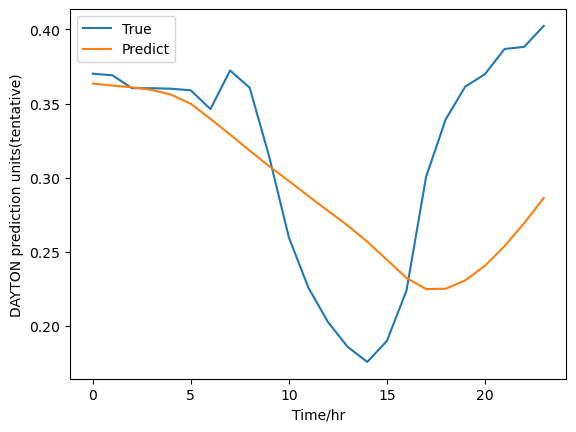

In [21]:
fig = plt.figure()
plt.plot(test_actual[0])
plt.plot(test_predict[0])
plt.xlabel('Time/hr')
plt.ylabel('DAYTON prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()


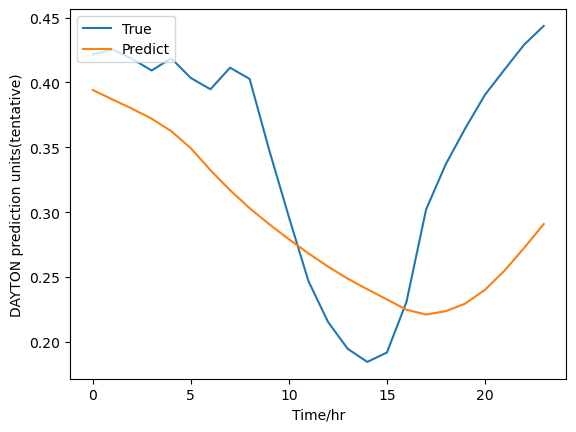

In [22]:
fig = plt.figure()
plt.plot(test_actual[1])
plt.plot(test_predict[1])
plt.xlabel('Time/hr')
plt.ylabel('DAYTON prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

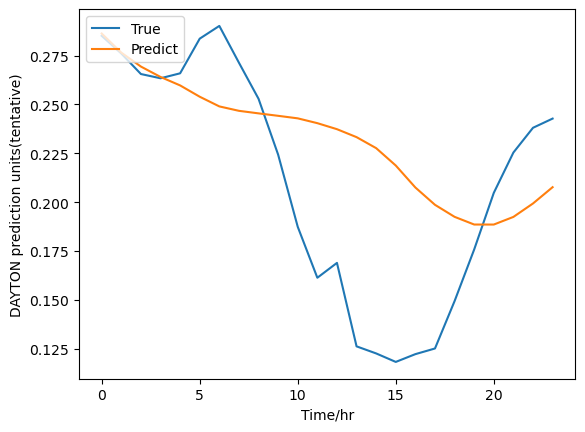

In [23]:
fig = plt.figure()
plt.plot(test_actual[200])
plt.plot(test_predict[200])
plt.xlabel('Time/hr')
plt.ylabel('DAYTON prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

###### 